**Performing PCA with an Undercomplete Linear Autoencoder:**
- Meaning of undercomplete: Internal representation of the autoencoder has a lower dimensionality than the input data. The autoencoder cannot trivially copy its inputs to the codings (outputs) - yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones). 

If the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing principal component analysis.

The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D

In [1]:
import tensorflow as tf

In [3]:
import numpy as np
from scipy.spatial.transform import Rotation

In [10]:
import matplotlib.pyplot as plt

In [17]:
from sklearn.manifold import TSNE

In [2]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])

autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)

autoencoder.compile(loss='mse', optimizer=optimizer)

In [4]:
m = 60
X = np.zeros((m, 3)) # initialize 3D dataset
np.random.seed(42)

angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [6]:
X_train.shape

(60, 3)

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)

In [8]:
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


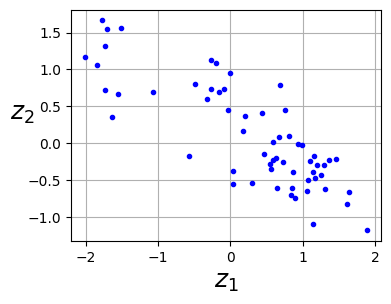

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

Note: This autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could - just like PCA.

**Stacked Autoencoders:**
- Just like other neural nets - autoencoders can have multiple hidden layers. In this case they are called stacked autoencoders (or deep autoencoders). Adding more layers helps the autoencoder learn more complex codings. That said - be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it learns to map each input to a single arbitrary number and the decoder learns the reverse mapping. needs to learn useful representations not just map the outputs to inputs. 

- The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). 

**Implementing a Stacked Autoencoder Using Keras:**
- You can implement a stacked autoencoder very much like a regular deep MLP

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [14]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")

history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0335 - val_loss: 0.0182
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0146 - val_loss: 0.0147
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 12/20
1719/1719 ━━━━━━━

**Visualizing the Reconstructions:**
- One way to ensure an autoencoder is properly trained is to compare the inputs and outputs: the differences should not be too significant. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


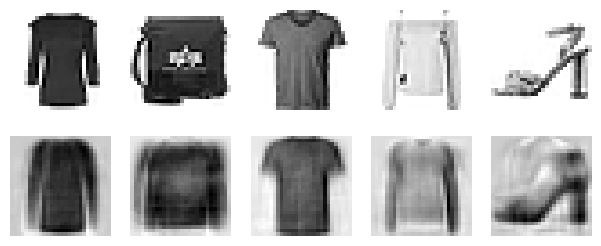

In [16]:
def plot_reconstructions(model, images=X_valid, n_images = 5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images*1.5,3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


plot_reconstructions(stacked_ae)
# save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions are recognizable - but a bit too lossy. We need to train the model for longer, or make the encoder and decoder deeper, or make the codings larger.But - making the network too powerful - will make it not learn any useful patterns so for now just stick with it.

**Visualizing the Fashion MNIST:**
- Now that we've trained a stacked autoencoder, we can use it to reduce the dataset's dimensionality. For visualization, this doesn't give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets with many instances and many features. So, one strategy is to use an autoencoder to reduce dimensionality then use another dimensionality reduction algorithm for visualization. 
- We use this strategy to visualize the fashion MNIST dataset. First, we'll use the encoder from before to reduce the dimensionality down to 30, then we'll use scikit-learn's implementation of t-SNE to reduce the dimensionality down to 2 for visualization. 

In [18]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


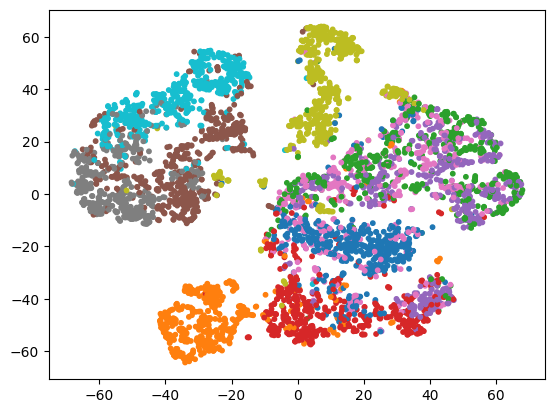

In [19]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

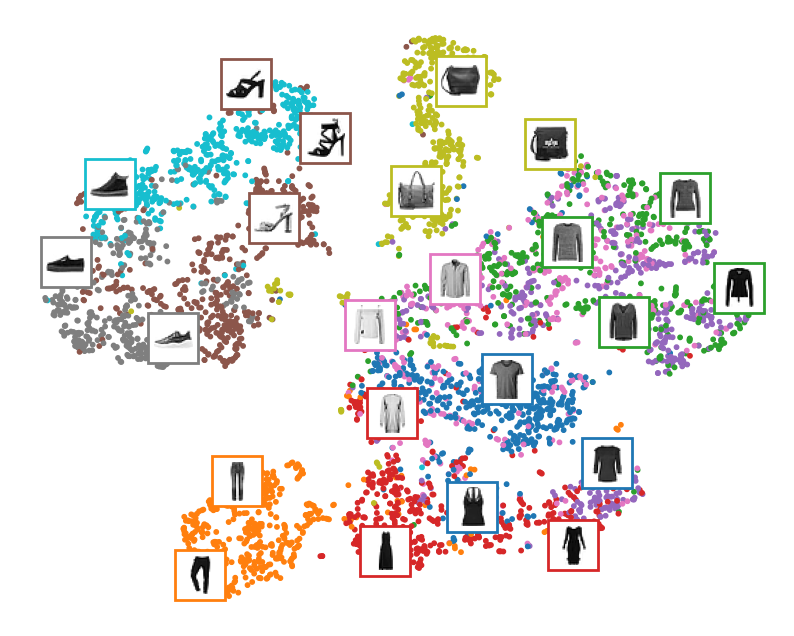

In [21]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

So - autoencoders can be used for dimensionality reduction. Another approach is for unsupervised pretraining:

**Unsupervised Pretraining using Stacked Autoencoders:**

Complex supervised task - w/o a lot of training data - one solution is to find a neural net that performs a similar task and to reuse its lower layers. 
- Similarly if you have a large dataset but most of it is ublabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural net for your actual task and train it with the labeled data. When training - if you really don't have much labeled training data - you may want to freeze the pretrained layers - at least the lower ones.

Next, we look at a few techniques for training stacked autoencoders:

**Tying Weights:**

When an autoencoder is neatly symmetrical - a common technique is to tie the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. Specifically, if the autoencoder has a total of N layers 

To tie the weights between layers using keras, lets define a custom layer:

In [35]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input.shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

Custom layer acts like a regular dense layer, but uses another dense layer's weights. However it uses its own bias vector Now, we can build a stacked autoencoder but with the decoder's dense layers tied to the encoder's dense layers:

In [36]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28,28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

In [37]:
# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = tied_ae.fit(X_train, X_train, epochs=10,validation_data=(X_valid, X_valid))

Epoch 1/10

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0345 - val_loss: 0.0174
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0169 - val_loss: 0.0159
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0138 - val_loss: 0.0138


Model achieves - roughly the same reconstruction error as the previous model - using almost half of the number of parameters

**Training one autoencoder at a time:**

Rather than training 

**Convolutional Autoencoders:**
- Here's a basic convolutional autoencoder for fashion mnist:

In [53]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 14x14x16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),# output: 7x7x32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 3x3x64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D() # output: (batch, 30)
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3*3*16),
    tf.keras.layers.Reshape((3,3,16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation="relu", padding="same"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28,28])
])

conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# compile and fit the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0450 - val_loss: 0.0202
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0170 - val_loss: 0.0160
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0125 - val_loss: 0.0124


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


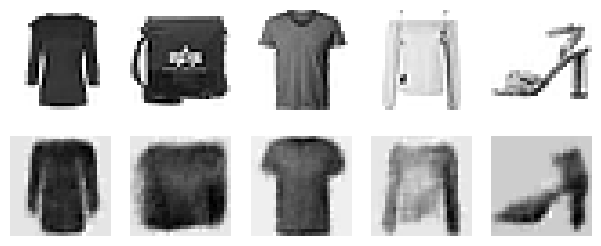

In [54]:
plot_reconstructions(conv_ae)
plt.show()

Formula for the output of a Conv2DTranspose layer:
- padding not same: output = strides*(input_height/width - 1) + filter_shape - (2*padding)
- if paddding is same: output = input_height * strides

checkout: [Stack_Overflow](https://stackoverflow.com/questions/50683039/conv2d-transpose-output-shape-using-formula)

Its also possible to have LSTM/RNN autoencoders, checkout this [repo](https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb)

Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer - making it undercomplete. There are actually many other kinds of constraints that can be used, including ones that allow the coding layer to just be as large as the inputs, or even larger, resulting in an overcomplete autoencoder. 

**Denoising Autoencoders:**
- Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise free inputs. 
- The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like dropout.
- The implementation is straightforward: regular stacked autoencoder with an additional dropout layer applied to the encoder's inputs (or, you could use a GaussianNoise layer instead). Recall that the dropout layer is only active during training - and so is the gaussian noise layer

In [55]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

In [56]:
# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0400 - val_loss: 0.0214
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0212 - val_loss: 0.0190
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0204 - val_loss: 0.0186
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0200 - val_loss: 0.0181
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0196 - val_loss: 0.0179
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0194 - val_loss: 0.0176
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0191 - val_loss: 0.0176
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0190 - val_loss: 0.0173
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0189 - val_loss: 0.0172


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


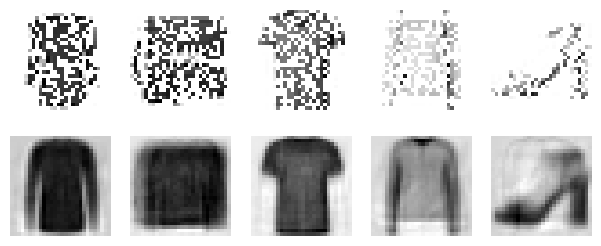

In [58]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

**Sparse Autoencoders:**
- another kind of constraint that often leads to good feature extraction is sparsity. By adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result - each neuron in the coding layer typically ends up representing a useful feature. 
- Simple approach is to use the sigmoid activation function in the coding layer - to constrain constrain the codings to values between 0 and 1, or use a large coding layer (e.g with 300 units) and add some l1 regularization to the coding layer's activations. The decoder on the other hand is just a regular decoder.

In [59]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1.0e-4)
])

sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0786 - val_loss: 0.0307
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0290 - val_loss: 0.0269
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0260 - val_loss: 0.0248
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0242 - val_loss: 0.0236
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0216 - val_loss: 0.0213
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0208 - val_loss: 0.0207
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0202 - val_loss: 0.0206
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0197 - val_loss: 0.0203
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0193 - val_loss: 0.0195


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


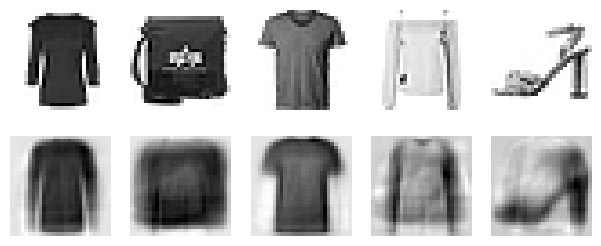

In [60]:
plot_reconstructions(sparse_l1_ae)
plt.show()

- another approach - often leads to better results is to measure the actual sparsity of the coding layer at each training iteration, and penalize the model when the measured sparsity diverges from a target sparsity. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. The batch size must not be too small, or else the mean won't be accurate.

In [61]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

In [62]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
             kl_divergence(self.target, mean_activities) +
             kl_divergence(1. - self.target, 1. - mean_activities)
        )

In [63]:
kld_reg = KLDivergenceRegularizer(weight=5.0e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(100, activation="relu"),
                                        tf.keras.layers.Dense(300, activation="sigmoid",
                                        activity_regularizer=kld_reg)
                                        ])
sparse_kl_decoder = tf.keras.Sequential([
                                        tf.keras.layers.Dense(100, activation="relu"),
                                        tf.keras.layers.Dense(28 * 28),
                                        tf.keras.layers.Reshape([28, 28])
                                        ])

sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0708 - val_loss: 0.0225
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0203 - val_loss: 0.0187
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0138 - val_loss: 0.0141
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0109 - val_loss: 0.0118
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.0099 - val_loss: 0.0101


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


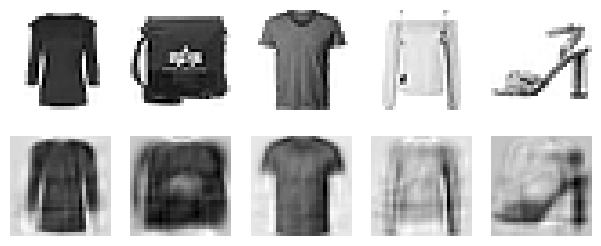

In [64]:
plot_reconstructions(sparse_kl_ae)
plt.show()

**Variational Autoencoders:**
- They are probabilistic autoencoders - meaning their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness during training)
- Most importantly - they are generative autoencoders - meaning they can generate new instances that look like they were sampled from the training set.

Althougth the inputs may have a very convoluted distribution, a variational autoencoder tends to produce codings that look as though they were sampled from a simple Gaussian distribution.(Variational autoencoders are actually more general; the codings are not limited to Gaussian distributions) - durinng training the cost function pushes the codings to gradually migrate within the coding space (aka latent space) to end up ooking like a cloud of gaussian points. One great consequence is that after training a variational autoencoder, you can very easily generate a new instance: just sample a random coding from the gaussian distribution and decode it - and voila

In [66]:
# building a variational autoencoder 
# - first, we need a custom layer to sample the codings given the mean and and sigma (std dev) or tweak n-dimensional vectors:

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var))*tf.exp(log_var/2)+mean

The sampling layer - takes 2 inputs => the mean and the log_var (tweak - instead of the standard deviation we use the log of the square of the standard deviation). Then we use the function tf.random.normal - to sample a random vector - of the same shape as the one of the inputs(log_var specifically here - so same shape as the codings vectors ). originally the tf.random.normal gets a distro with mean 0 and std 1 - but we scale it - multiply by exp(tweak/2) - equal to the standard deviation and finally add the mean => this samples a coddings vector from the gaussian distribution with mean mhu and std sigma.

Next - we create the encoder, using the functional API because the model is not entirely sequential:

In [67]:
codings_size = 10

inputs = tf.keras.layers.Input(shape = [28,28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

Note - the dense layers that output the codings_mean and codings_log_var have the same inputs (the outputs of the second dense layer) - we then pass both the codings mean and codings log var to the sampling layer. finally, the variational encoder model has 3 outputs => only the codings are required but we add codings_mean and codings_log_var as well - incase we want to inspect their values. 

Now - let's build the decoder:

In [74]:
import keras.ops as ops

In [68]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28*28)(x)
outputs = tf.keras.layers.Reshape([28,28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [69]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

we ignore the first 2 outputs of the encoder - we only want to feed the codings to the decoder - Lastly, we must add the latent loss and the reconstruction loss:

In [75]:
latent_loss = -0.5 * ops.mean(ops.sum(1 + codings_log_var - ops.square(codings_mean) - ops.exp(codings_log_var), axis=-1))

In [77]:
# first apply this eqn - general latent loss eqn to compute the latent loss for each instance in the batch summing over the 
# last axis
# latent_loss = -0.5 * tf.reduce_sum(
#     1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
#     axis=-1)
# latent_loss = -0

# then we compute the mean loss over all the instances in the batch, and divide the result by 784 to ensure it has the appropriate
# scale compared to the reconstruction loss
variational_ae.add_loss(latent_loss)

NotImplementedError: 

Picking up an example from the keras doc - on VAEs:

In [147]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [148]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


Build the encoder:

In [153]:
codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings], name="encoder")
variational_encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 784)       │          0 │ input_layer_42[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 150)       │    117,750 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 100)       │     15,100 │ dense_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 10)        │      1,010 │ dense_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 10)        │      1,010 │ dense_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 10)        │          0 │ dense_52[0][0],   │
│ (Sampling)          │                   │            │ dense_53[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,870 (526.84 KB)

 Trainable params: 134,870 (526.84 KB)

 Non-trainable params: 0 (0.00 B)

Build the decoder:

In [154]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs], name="decoder")
variational_decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 100)            │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 150)            │        15,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 784)            │       118,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,634 (525.91 KB)

 Trainable params: 134,634 (525.91 KB)

 Non-trainable params: 0 (0.00 B)

Define the VAE as a Model with a custom train step:

In [188]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = keras.Variable(0.0, trainable=False)  # For KL annealing

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, inputs, training=False):
        """Define the forward pass for the VAE."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=1,
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        grads = [tf.clip_by_norm(g, clip_norm=1.0) for g in grads]  # Clip gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.mean_squared_error(data, reconstruction),
                axis=1,
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + self.beta*kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def on_epoch_begin(self, epoch, logs=None):
        # Linearly increase beta from 0 to 1 over 10 epochs
        self.beta.assign(tf.minimum(1.0, epoch / 10.0))

In [189]:
vae = VAE(variational_encoder, variational_decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0e-4))
vae.fit(X_train, epochs=30, batch_size=128, validation_data=(X_valid))

Epoch 1/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 16.5857 - loss: 9.7260 - reconstruction_loss: 9.7260 - val_kl_loss: 20.4966 - val_loss: 1.3371 - val_reconstruction_loss: 1.3371
Epoch 2/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 21.3243 - loss: 9.6942 - reconstruction_loss: 9.6942 - val_kl_loss: 23.7458 - val_loss: 1.3409 - val_reconstruction_loss: 1.3409
Epoch 3/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 24.3141 - loss: 9.6805 - reconstruction_loss: 9.6805 - val_kl_loss: 26.3865 - val_loss: 1.3603 - val_reconstruction_loss: 1.3603
Epoch 4/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - kl_loss: 26.8695 - loss: 9.6709 - reconstruction_loss: 9.6709 - val_kl_loss: 28.6874 - val_loss: 1.3677 - val_reconstruction_loss: 1.3677
Epoch 5/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - kl_loss: 29.0315 - loss: 9.6652 - reconstruction_loss: 9.6652 - val_kl_loss: 30.6232 - val_loss: 1.3906 - val_reconstruction_loss: 1.3906
Epoch 6/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


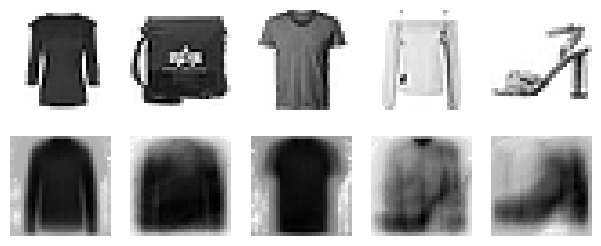

In [190]:
plot_reconstructions(vae)
plt.show()

In [176]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            z_sample = np.array([[xi, 10]])
            print(z_sample.shape)
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

(1, 2)


ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 10), found shape=(1, 2)

In [164]:
ops.mean(ops.sum(keras.losses.mean_squared_error(a,b), axis=1))

<tf.Tensor: shape=(), dtype=float64, numpy=4.655748060965992>